# SIR Epidemiology model: Outbreak on Tristan de Cunha

This example shows how the [SIR model](http://pints.readthedocs.io/en/latest/toy/sir_model.html) can be used.

The SIR model describes a disease breaking out in a population split into a susceptible (S), infected (I), and recovered (R) part (see [wikipedia](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model)).

The formulation shown here was used by [Toni et al.](http://rsif.royalsocietypublishing.org/content/6/31/187.short), in a paper in which they also give real data of a common-cold outbreak on the isle of Tristan de Cunha (originally from [Hammond & Tyrrell](https://www.cambridge.org/core/journals/epidemiology-and-infection/article/mathematical-model-of-commoncold-epidemics-on-tristan-da-cunha/787670BB798E292A9AFE59B6B51DE57A) and [Shibli et al.](https://www.cambridge.org/core/journals/epidemiology-and-infection/article/common-colds-on-tristan-da-cunha/D83E74AB677CCBC74E71A319EAD6C330)). In this formulation, the susceptible population is unknown, the we can observe the infected and recovered population.

The model has three parameters: infection rate ``gamma``, recovery rate ``v``, and the initial susceptible population ``S0``.



Parameters:
[0.026, 0.285, 38]


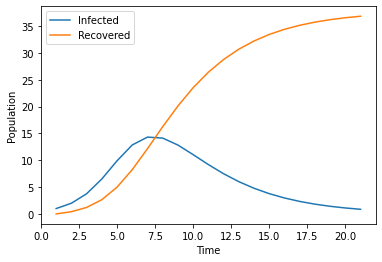

In [1]:
import pints
import pints.toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Create a model
model = pints.toy.SIRModel()

# Run a simulation
parameters = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(parameters, times)

print('Parameters:')
print(parameters)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(times, values)
plt.legend(['Infected', 'Recovered'])
plt.show()

We can have a look at the real data too:

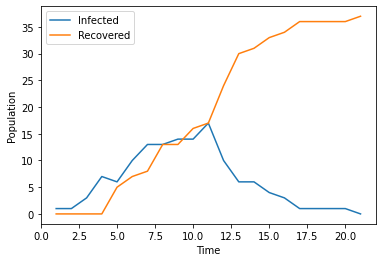

In [2]:
real_values = model.suggested_values()

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(times, real_values)
plt.legend(['Infected', 'Recovered'])
plt.show()

Next, we set up a problem. Because this model has multiple outputs (2), we use a [MultiOutputProblem](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#multi-output-problem).

In [3]:
problem = pints.MultiOutputProblem(model, times, real_values)
score = pints.SumOfSquaresError(problem)

To create a probabilistic model, we'll assume the data can be perfectly described by the model + Gausian noise with an unknown standard deviation `sigma1` in I and `sigma2` in R.

In [4]:
loglikelihood = pints.GaussianLogLikelihood(problem)

We can now use MCMC to have a guess at the parameters! We'll try to infer two noise parameters at the same time.

In [5]:
# Starting points
x0 = [
    [0.001, 0.20, 52, 3, 3],
    [0.05, 0.34, 34, 3, 3],
    [0.02, 0.18, 20, 3, 3],
]

# Create MCMC routine
mcmc = pints.MCMCController(loglikelihood, 3, x0)
mcmc.set_max_iterations(3000)
mcmc.set_log_to_screen(False)
chains = mcmc.run()

We now have a look at the rhat and traces, to get an indication of how well the chains have converged:

param           mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
--------------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
gamma           0.02    0.00    0.02    0.02   0.02   0.02   0.03     1.09    31.33  4.63
v               0.27    0.03    0.22    0.26   0.27   0.28   0.32     1.04    91.05  13.47
S_0             40.52   3.81    30.74   39.61  40.86  41.90  49.82    1.14    25.65  3.79
sigma infected  2.43    0.69    1.58    1.92   2.21   2.78   4.00     1.36    29.60  4.38
sigma recovery  2.24    0.63    1.47    1.84   2.08   2.46   4.15     1.21    24.87  3.68


<Figure size 432x288 with 0 Axes>

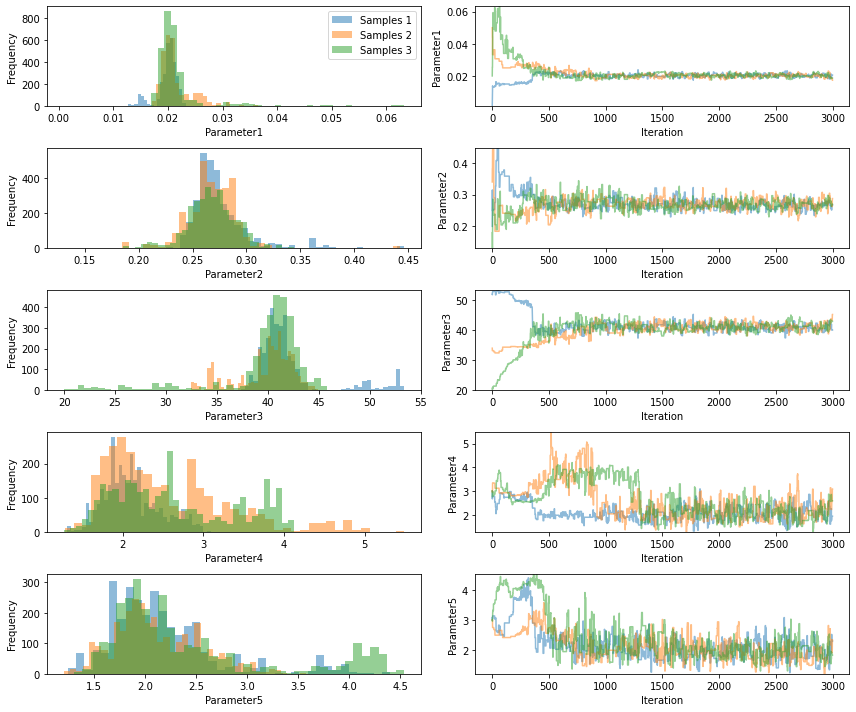

In [6]:
# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['gamma', 'v', 'S_0', 'sigma infected', 'sigma recovery'])
print(results)

plt.figure()
pints.plot.trace(chains)
plt.show()

Finally, we compare some predictions based on the final samples to the real data:

<Figure size 432x288 with 0 Axes>

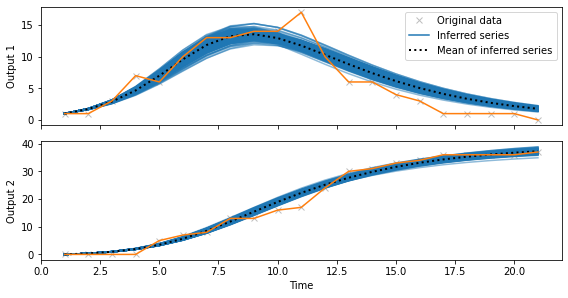

In [7]:
samples = chains[0, -1000:]

plt.figure()
fig, axes = pints.plot.series(samples, problem)
axes[0].plot(times, real_values[:, 0], c='#ff7f0e')
axes[1].plot(times, real_values[:, 1], c='#ff7f0e')
plt.show()